# **Import the libraries**

In [ ]:
from enum import Enum
from functools import partial
import pandas as pd
import torch
import json

from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from datasets import load_dataset
from trl import SFTConfig,SFTTrainer
from peft import LoraConfig, TaskType

seed=42
set_seed(42)

import os
os.environ['HF_TOKEN'] = '*******'

# **Preprocess the dataset**

In [ ]:
model_name = "google/gemma-2-2b-it"
dataset_name = "Jofthomas/hermes-function-calling-thinking-V1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
tokenizer.chat_template = "{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{{ '<start_of_turn>' + message['role'] + '\n' + message['content'] | trim + '<end_of_turn><eos>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"


In [ ]:
def preprocess(sample):
    messages = sample['messages']
    first_message = messages[0]

    # Instead of adding a system message, we merge the content into the first user message
    if first_message["role"] == "system":
        system_message_content = first_message["content"]
        messages[1]["content"] = system_message_content + "Also, before making a call to a function take the time to plan the function to take. Make that thinking process between <think>{your thoughts}</think>\n\n" + messages[1]["content"]
        messages.pop(0)
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}


In [ ]:
dataset = load_dataset(dataset_name)
dataset = dataset.rename_column("conversations", "messages")

README.md:   0%|          | 0.00/354 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3570 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.map(preprocess,remove_columns="messages")
dataset = dataset['train'].train_test_split(0.1)
dataset

Map:   0%|          | 0/3570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3213
    })
    test: Dataset({
        features: ['text'],
        num_rows: 357
    })
})

In [ ]:
# Let's look at how we formatted the dataset
print(dataset["train"][8]["text"])


<bos><start_of_turn>human
You are a function calling AI model. You are provided with function signatures within <tools></tools> XML tags.You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions.Here are the available tools:<tools> [{'type': 'function', 'function': {'name': 'get_news_headlines', 'description': 'Get the latest news headlines', 'parameters': {'type': 'object', 'properties': {'country': {'type': 'string', 'description': 'The country for which headlines are needed'}}, 'required': ['country']}}}, {'type': 'function', 'function': {'name': 'search_recipes', 'description': 'Search for recipes based on ingredients', 'parameters': {'type': 'object', 'properties': {'ingredients': {'type': 'array', 'items': {'type': 'string'}, 'description': 'The list of ingredients'}}, 'required': ['ingredients']}}}] </tools>Use the following pydantic model json schema for each tool call you will make: {'title': 'FunctionCall

# **Modify Tokenizer**

In [ ]:
class ChatmlSpecialTokens(str,Enum):
    tools = "<tools>"
    eotools = "</tools>"
    think = "<think>"
    eothink = "</think>"
    tool_call = "<tool_call>"
    eotool_call = "</tool_call>"
    tool_response = "<tool_response>"
    eotool_response = "</tool_response>"
    pad_token = "<pad>"
    eos_token = "<eos>"

    @classmethod
    def list(cls):
        return [c.value for c in cls]


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    additional_special_tokens=ChatmlSpecialTokens.list(),
    pad_token = ChatmlSpecialTokens.pad_token.value
)

* Indeed, as we saw in Unit 1, the tokenizer splits text into sub-words by default. This is not what we want for our new special tokens!

* While we segmented our example using <think>, <tool_call>, and <tool_response>, the tokenizer does not yet treat them as whole tokens—it still tries to break them down into smaller pieces. To ensure the model correctly interprets our new format, we must add these tokens to our tokenizer.

* Additionally, since we changed the chat_template in our preprocess function to format conversations as messages within a prompt, we also need to modify the chat_template in the tokenizer to reflect these changes.

In [ ]:
tokenizer.chat_template = "{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{{ '<start_of_turn>' + message['role'] + '\n' + message['content'] | trim + '<end_of_turn><eos>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             attn_implementation='eager',
                                             device_map="auto")

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
model.resize_token_embeddings(len(tokenizer))
model.to(torch.bfloat16)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256008, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

# **LORA Config**

In [ ]:
from peft import LoraConfig
rank_dimension = 16
lora_alpha = 64
lora_dropout = 0.05

peft_config = LoraConfig(
    r = rank_dimension,
    lora_alpha= lora_alpha,
    lora_dropout= lora_dropout,
    target_modules = ['gate_proj','q_proj','k_proj','v_proj','lm_head','o_proj','embed_tokens','down_proj','up_proj'],
    task_type=TaskType.CAUSAL_LM
)

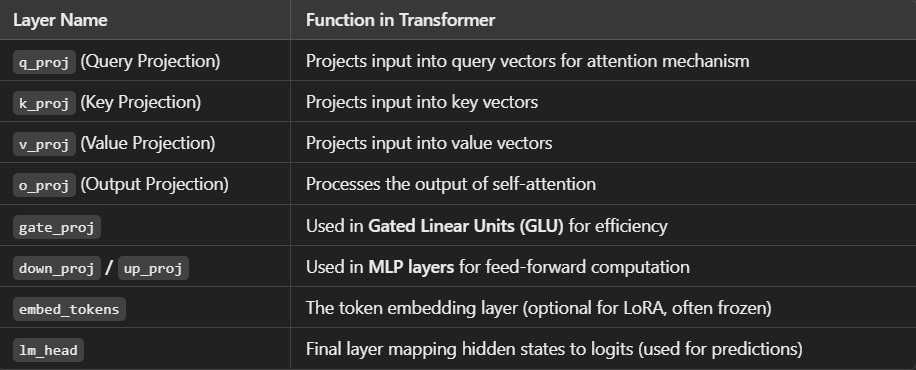

# **SFTT Config**

In [ ]:
output_dir = "gemma-2-2B-it-thinking-function_calling-V0" # The directory where the trained model checkpoints, logs, and other artifacts will be saved. It will also be the default name of the model when pushed to the hub if not redefined later.
per_device_train_batch_size = 1
per_device_eval_batch_size = 1
gradient_accumulation_steps = 4
logging_steps = 5
learning_rate = 1e-4 # The initial learning rate for the optimizer.

max_grad_norm = 1.0
num_train_epochs=1
warmup_ratio = 0.1
lr_scheduler_type = "cosine"
max_seq_length = 1500

training_arguments = SFTConfig(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    save_strategy="no",
    eval_strategy="epoch",
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    max_grad_norm=max_grad_norm,
    weight_decay=0.1,
    warmup_ratio=warmup_ratio,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard",
    bf16=True,
    hub_private_repo=False,
    push_to_hub=False,
    num_train_epochs=num_train_epochs,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    packing=True,
    max_seq_length=max_seq_length,
)

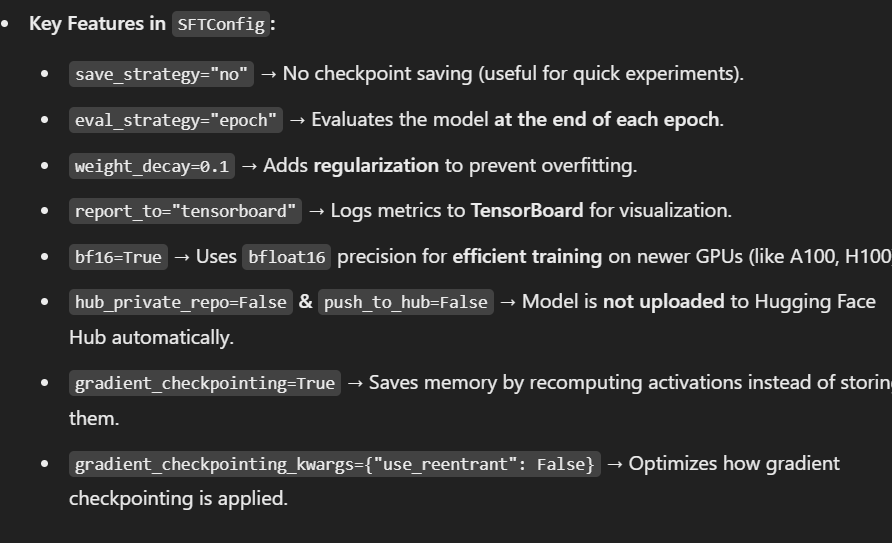

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
    peft_config=peft_config,
)


/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


Converting train dataset to ChatML:   0%|          | 0/3213 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/3213 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3213 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/3213 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/357 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/357 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/357 [00:00<?, ? examples/s]

Packing eval dataset:   0%|          | 0/357 [00:00<?, ? examples/s]

In [ ]:
trainer.train()
trainer.save_model()

# **Push to Hugging Face**

In [ ]:
trainer.push_to_hub(f"{username}/{output_dir}")


In [ ]:
tokenizer.eos_token = "<eos>"
# push the tokenizer to hub ( replace with your username and your previously specified
tokenizer.push_to_hub(f"{username}/{output_dir}", token=True)


# **Load the PEFT Model**

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import torch

#load the peft lora parameters
peft_model_id = f"{username}/{output_dir}" # replace with your newly trained adapter
device = "auto"
config = PeftConfig.from_pretrained(peft_model_id)

#load the base model
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                             device_map="auto",
                                             )

#load tokenizer and resize base tokenizer
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
model.resize_token_embeddings(len(tokenizer))

# Wraps the base model with the LoRA adapter. Now, the model only applies LoRA-modified layers, while keeping most weights frozen.

model = PeftModel.from_pretrained(model, peft_model_id)
model.to(torch.bfloat16)
model.eval()

# **Evaluate**

In [ ]:
#this prompt is a sub-sample of one of the test set examples. In this example we start the generation after the model generation starts.
prompt="""<bos><start_of_turn>human
You are a function calling AI model. You are provided with function signatures within <tools></tools> XML tags.You may call one or more functions to assist with the user query. Don't make assumptions about what values to plug into functions.Here are the available tools:<tools> [{'type': 'function', 'function': {'name': 'convert_currency', 'description': 'Convert from one currency to another', 'parameters': {'type': 'object', 'properties': {'amount': {'type': 'number', 'description': 'The amount to convert'}, 'from_currency': {'type': 'string', 'description': 'The currency to convert from'}, 'to_currency': {'type': 'string', 'description': 'The currency to convert to'}}, 'required': ['amount', 'from_currency', 'to_currency']}}}, {'type': 'function', 'function': {'name': 'calculate_distance', 'description': 'Calculate the distance between two locations', 'parameters': {'type': 'object', 'properties': {'start_location': {'type': 'string', 'description': 'The starting location'}, 'end_location': {'type': 'string', 'description': 'The ending location'}}, 'required': ['start_location', 'end_location']}}}] </tools>Use the following pydantic model json schema for each tool call you will make: {'title': 'FunctionCall', 'type': 'object', 'properties': {'arguments': {'title': 'Arguments', 'type': 'object'}, 'name': {'title': 'Name', 'type': 'string'}}, 'required': ['arguments', 'name']}For each function call return a json object with function name and arguments within <tool_call></tool_call> XML tags as follows:
<tool_call>
{tool_call}
</tool_call>Also, before making a call to a function take the time to plan the function to take. Make that thinking process between <think>{your thoughts}</think>

Hi, I need to convert 500 USD to Euros. Can you help me with that?<end_of_turn><eos>
<start_of_turn>model
<think>"""

#tokenize without special tokens
inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
inputs = {k: v.to("cuda") for k,v in inputs.items()}
outputs = model.generate(**inputs,
                         max_new_tokens=300,# Adapt as necessary
                         do_sample=True,
                         top_p=0.95,
                         temperature=0.01,
                         repetition_penalty=1.0,
                         eos_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(outputs[0]))